In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import seaborn as sns

from collections import OrderedDict

In [2]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis/final_analysis/')

from process_helper import *
from plot_helper import *
save_mode = ".pdf"
font_size = 18
color_palette = ["black", "grey"]

In [3]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')

/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Load data

In [4]:
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [5]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})
data_choice_level = df_choice_add_features(data_choice_level, add_first_move=0)
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
data_puzzle_level = df_map_add_features(data_puzzle_level, data_choice_level)
single_condition_data = data_puzzle_level[data_puzzle_level['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [6]:
data_subset_before1undo = df_subset_1undo_submit(sc_data_choice_level)
state_undo_1undo = df_subset_1state(data_subset_before1undo, data_puzzle_level, single_condition_data, f"(firstUndo ==1)", 1)
state_notundo_1undo = df_subset_1state(data_subset_before1undo, data_puzzle_level, single_condition_data, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

# Save state_df_1undo to csv
state_df_1undo.to_csv(data_dir + 'state_df_1undo.csv', index=False)

# only keep rows with RPE to be non-na
# state_df_1undo = state_df_1undo[state_df_1undo['RPE'].notna()]

# Task difficulty 

In [23]:
print(spearmanr(state_undo_1undo.groupby(['puzzleID'])['RT1'].mean() , state_undo_1undo.groupby(['puzzleID'])['RT1_basic'].mean()))

SpearmanrResult(correlation=0.3832870798643231, pvalue=0.008556264654786983)


## First-move RT

In [7]:
# state_df_1undo['RT1_log'] = np.log(state_df_1undo['RT1'])
print(min(state_df_1undo['RT1_log']))
print(max(state_df_1undo['RT1_log']))
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=[0.5,1.5,2.5,3.5], labels=range(1,4), retbins=True)
# temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1#.astype(int)
# temp2, cutoff = pd.cut(state_df_1undo['RT1_basic_log'], bins=5, labels=range(1,6),retbins=True)
# state_df_1undo['rt1_basic_bin'] = temp2.astype(int)

0.5399960010657705
4.883173065825409


In [22]:
state_df_1undo['cumulative_error_cat'] = state_df_1undo['cumulative_error'].apply(lambda x: '>2' if x > 2 else str(x))
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin','cumulative_error_cat'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin','cumulative_error_cat'])['firstUndo'].count()


rt1_bin  cumulative_error_cat
1        0                       97
         1                       91
         2                       72
         >2                      39
2        0                       97
         1                       96
         2                       83
         >2                      42
3        0                       37
         1                       35
         2                       22
         >2                      11
Name: firstUndo, dtype: int64

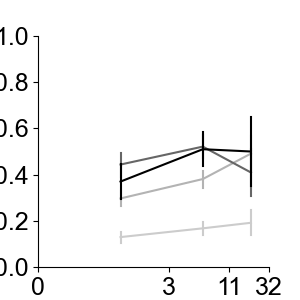

In [43]:
%matplotlib widget
import matplotlib.ticker
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
plt.rcParams.update({'font.size': font_size})

plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "cumulative_error_cat", 
             palette = OrderedDict({
                        '0': '#CCCCCC',  
                        '1': '0.7',  # light grey
                        '2': '0.4',  # medium grey
                        '>2': '0.0'  # dark grey
}),
             err_style = "bars",
             errorbar = "se"
             )


# only use 1 decimal place
# cutoff_round = [round(i,1) for i in cutoff]
# axs.set_xticks(np.arange(0.5, 4.5, 1))

axs.set_xscale('log')
axs.set_xticks([0.5,1.5,2.5,3.5])

axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs.get_xaxis().set_tick_params(which='minor', size=0)
axs.get_xaxis().set_tick_params(which='minor', width=0) 
from matplotlib.ticker import ScalarFormatter, NullFormatter
for axis in [axs.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
axs.set_xticklabels([int(x)-1 for x in np.exp([0.5,1.5,2.5,3.5])])
# plt.xticklabels([round(x,1) for x in np.exp([0.5,1.5,2.5,3.5])])
# axs.set_xticklabels(cutoff_round)

handles = axs.get_legend_handles_labels()[0]  # get the handles
labels = axs.get_legend_handles_labels()[1]   # get the labels
order = [0,1,2,3]
axs.legend([handles[idx] for idx in order], 
           [labels[idx] for idx in order],
           frameon=False, 
           bbox_to_anchor=(3, 0),
           title='Cumulative \nerror magnitude')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
axs.set_yticks(np.arange(0, 1.2, 0.2))
axs.set(xlabel='First-move RT (s)', ylabel='Probability of undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt_cumulative_error'+save_mode, dpi=300, bbox_inches='tight')
plt.show()

In [37]:
state_df_1undo_select = state_df_1undo[["subjects","puzzleID","RT1_log","action_gap","cumulative_error","firstUndo"]]


In [35]:

%%R -i state_df_1undo_select,out_dir2
state_df_1undo_select$subjects <- as.factor(state_df_1undo_select[,"subjects"])
state_df_1undo_select$puzzleID <- as.factor(state_df_1undo_select[,"puzzleID"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log*cumulative_error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo_select, family = binomial(link="logit"))
model_undo2 = lme4::glmer(firstUndo ~  1 + cumulative_error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo_select, family = binomial(link="logit"))
print(anova(model_undo,model_undo2))
# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Data: state_df_1undo_select
Models:
model_undo2: firstUndo ~ 1 + cumulative_error + (1 | subjects) + (1 | puzzleID)
model_undo: firstUndo ~ 1 + RT1_log * cumulative_error + (1 | subjects) + 
model_undo:     (1 | puzzleID)
            npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model_undo2    4 3080.8 3106.2 -1536.4   3072.8                         
model_undo     6 3067.2 3105.2 -1527.6   3055.2 17.648  2  0.0001472 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log * cumulative_error + (1 | subjects) +  
    (1 | puzzleID)
   Data: state_df_1undo_select

     AIC      BIC   logLik deviance df.resid 
  3067.2   3105.2  -1527.6   3055.2     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0252 -0.3890 -0.1274  0.0755 10.6626 

Random effects:
 Groups   Name        Variance Std

## Action gap 

In [18]:
temp1, cutoff = pd.cut(state_df_1undo['action_gap'], bins=[2,3,4,5,6], labels=range(1,5), retbins=True)
# temp1, cutoff = pd.cut(state_df_1undo['action_gap'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['action_gap_bin'] = temp1.astype(int)


In [9]:
firstUndo_sub = state_df_1undo.groupby(['subjects','puzzleID','action_gap_bin','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['action_gap_bin','error'])['firstUndo'].count()

action_gap_bin  error
1               False     286
                True      165
2               False    1024
                True     1324
3               False     481
                True      700
4               False      56
                True      122
Name: firstUndo, dtype: int64

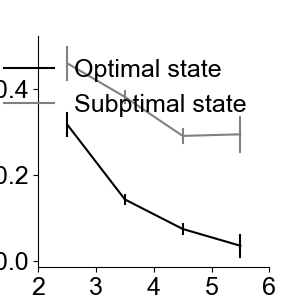

In [11]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
plt.rcParams.update({'font.size': font_size})
# multiple line plot    
sns.lineplot(x='action_gap_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "error",
             palette = color_palette,
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 5.5, 1))
axs.set_xticklabels(cutoff_round)
axs.legend(labels=['Optimal state','Subptimal state'], frameon=False, loc='upper right')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Action Gap', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_action_gap'+save_mode, dpi=300, bbox_inches='tight')
plt.show()

In [19]:
firstUndo_sub = state_df_1undo.groupby(['subjects','puzzleID','action_gap_bin','cumulative_error_cat'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['action_gap_bin','cumulative_error_cat'])['firstUndo'].count()

action_gap_bin  cumulative_error_cat
1               0                        286
                1                        123
                2                         36
                >2                         6
2               0                       1024
                1                        950
                2                        271
                >2                       103
3               0                        481
                1                        468
                2                        174
                >2                        58
4               0                         56
                1                         78
                2                         14
                >2                        30
Name: firstUndo, dtype: int64

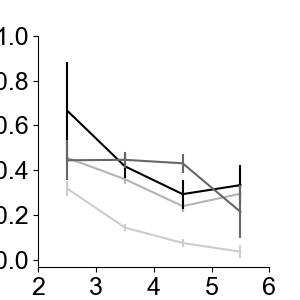

In [20]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
plt.rcParams.update({'font.size': font_size})
# multiple line plot    
sns.lineplot(x='action_gap_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "cumulative_error_cat",
             palette = OrderedDict({
    '0': '#CCCCCC',  
    '1': '0.7',  # light grey
    '2': '0.4',  # medium grey
    '>2': '0.0'  # dark grey
}),
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 5.5, 1))
axs.set_xticklabels(cutoff_round)

# After your plot, before creating the legend:
handles = axs.get_legend_handles_labels()[0]  # get the handles
labels = axs.get_legend_handles_labels()[1]   # get the labels
order = [1,0,3,2]
axs.legend([handles[idx] for idx in order], 
           [labels[idx] for idx in order],
           frameon=False, 
           bbox_to_anchor=(2, 0))

# hide legend
# axs.get_legend().remove()

axs.set_yticks(np.arange(0, 1.2, 0.2))
axs.set(xlabel='Action gap', ylabel='Probability of undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_action_gap_cumulative_error'+save_mode, dpi=300, bbox_inches='tight')
plt.show()

In [21]:

%%R 

model_undo = lme4::glmer(firstUndo ~  1 + action_gap*error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))
# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + action_gap * error + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  3038.8   3076.8  -1513.4   3026.8     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4570 -0.3637 -0.1404  0.0684  8.5662 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 7.2065   2.6845  
 puzzleID (Intercept) 0.2388   0.4886  
Number of obs: 4158, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            3.0744     0.8141   3.777 0.000159 ***
action_gap            -1.7399     0.2152  -8.086 6.15e-16 ***
errorTRUE             -1.5834     0.7569  -2.092 0.036433 *  
action_gap:errorTRUE   1.1334     0.2119   5.349 8.86e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

In [39]:
%%R -i state_df_1undo_select,out_dir2
state_df_1undo_select$subjects <- as.factor(state_df_1undo_select[,"subjects"])
state_df_1undo_select$puzzleID <- as.factor(state_df_1undo_select[,"puzzleID"])

model_undo = lme4::glmer(firstUndo ~  1 + action_gap*cumulative_error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo_select, family = binomial(link="logit"))
model_undo2 = lme4::glmer(firstUndo ~  1 + cumulative_error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo_select, family = binomial(link="logit"))
print(anova(model_undo,model_undo2))
# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Data: state_df_1undo_select
Models:
model_undo2: firstUndo ~ 1 + cumulative_error + (1 | subjects) + (1 | puzzleID)
model_undo: firstUndo ~ 1 + action_gap * cumulative_error + (1 | subjects) + 
model_undo:     (1 | puzzleID)
            npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model_undo2    4 3080.8 3106.2 -1536.4   3072.8                         
model_undo     6 3050.9 3088.9 -1519.5   3038.9 33.929  2   4.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + action_gap * cumulative_error + (1 | subjects) +  
    (1 | puzzleID)
   Data: state_df_1undo_select

     AIC      BIC   logLik deviance df.resid 
  3050.9   3088.9  -1519.5   3038.9     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.7087 -0.3905 -0.1275  0.0724 12.9146 

Random effects:
 Groups   Name        Varian

## rule out other retrospective factors

In [9]:
print(spearmanr(state_undo_1undo.groupby(['puzzleID'])['RT1'].mean() , state_undo_1undo.groupby(['puzzleID'])['cumulative_error'].mean()))
print(spearmanr(state_undo_1undo.groupby(['puzzleID'])['RT1'].mean() , state_undo_1undo.groupby(['puzzleID'])['error'].mean()))

SpearmanrResult(correlation=0.1414166333275896, pvalue=0.34852137169883546)
SpearmanrResult(correlation=0.18189150102918966, pvalue=0.22634771259617853)


In [8]:
%%R -i state_df_1undo

error_rt1 = lme4::glmer(cumulative_error ~  1 + RT1_log + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo)
summary(error_rt1)

Linear mixed model fit by REML ['lmerMod']
Formula: cumulative_error ~ 1 + RT1_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

REML criterion at convergence: 9736.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0078 -0.6390 -0.1644  0.5305  5.5284 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1502   0.3876  
 puzzleID (Intercept) 0.1330   0.3647  
 Residual             0.5534   0.7439  
Number of obs: 4158, groups:  subjects, 100; puzzleID, 46

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.60565    0.08148   7.433
RT1_log      0.12019    0.02832   4.244

Correlation of Fixed Effects:
        (Intr)
RT1_log -0.562


In [8]:
print(spearmanr(state_undo_1undo.groupby(['puzzleID'])['action_gap'].mean() , state_undo_1undo.groupby(['puzzleID'])['error'].mean()))
print(spearmanr(state_undo_1undo.groupby(['puzzleID'])['action_gap'].mean() , state_undo_1undo.groupby(['puzzleID'])['cumulative_error'].mean()))

SpearmanrResult(correlation=0.4866542132650219, pvalue=0.0006048835206200214)
SpearmanrResult(correlation=0.5525195841016098, pvalue=6.852486759367743e-05)


In [ ]:
df_noundo = data_choice_level[data_choice_level['condition']==0].copy()
df_noundo = df_noundo.merge(single_condition_data[["subjects","puzzleID", "action_gap", "RT1"]], on=["subjects","puzzleID"], how = "left")
print(spearmanr(df_noundo.groupby(['puzzleID'])['action_gap'].mean() , df_noundo.groupby(['puzzleID'])['error'].mean()))
print(spearmanr(df_noundo.groupby(['puzzleID'])['RT1'].mean() , df_noundo.groupby(['puzzleID'])['error'].mean()))
print(spearmanr(df_noundo.groupby(['puzzleID'])['RT1'].mean() , df_noundo.groupby(['puzzleID'])['cumulative_error'].mean()))
print(spearmanr(df_noundo.groupby(['puzzleID'])['action_gap'].mean() , df_noundo.groupby(['puzzleID'])['cumulative_error'].mean()))

SpearmanrResult(correlation=0.26564282863342314, pvalue=0.07437404563542763)
SpearmanrResult(correlation=0.15831508842212058, pvalue=0.29333200914620394)
SpearmanrResult(correlation=0.11563367252543941, pvalue=0.4441199055816396)
SpearmanrResult(correlation=0.4151967443446188, pvalue=0.004114175528934338)


# Number of connected cities

In [11]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$puzzleID <- as.factor(state_df_1undo[,"puzzleID"])

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]

     AIC      BIC   logLik deviance df.resid 
  1059.6   1081.7   -525.8   1051.6     1843 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4616 -0.2608 -0.1137 -0.0469  6.8354 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.7084   2.9510  
 puzzleID (Intercept) 0.9124   0.9552  
Number of obs: 1847, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     5.0622     1.6003   3.163  0.00156 ** 
currNumCities  -1.0569     0.1911  -5.531 3.19e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.962


# Context RPE

## check the correlation between predictors

In [21]:
test = state_df_1undo.loc[state_df_1undo.cumulative_error==0,:]
# print(spearmanr(test.groupby(['subjects'])['cumulative_error'].mean() , test.groupby(['subjects'])['RPE'].mean()))
print(spearmanr(test.groupby(['subjects'])['currNumCities'].mean() , test.groupby(['subjects'])['RPE'].mean()))
print(spearmanr(state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RT1_log'].mean() , state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RPE'].mean()))

SpearmanrResult(correlation=0.27554470082699956, pvalue=0.0057718510472138055)
SpearmanrResult(correlation=-0.044823747680890536, pvalue=0.6595402434931723)


## undo

In [24]:
%%R -i state_df_1undo
model0 = lme4::glmer(firstUndo ~  1 + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
model1 = lme4::glmer(firstUndo ~  1 + RPE + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
model2 = lme4::glmer(firstUndo ~  1 + avg_numCities_before + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
print(summary(model0))
print(summary(model1))
print(summary(model2))
# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]

     AIC      BIC   logLik deviance df.resid 
  1044.5   1066.5   -518.2   1036.5     1821 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5462 -0.2579 -0.1149 -0.0474  6.7645 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.6307   2.9378  
 puzzleID (Intercept) 0.9523   0.9759  
Number of obs: 1825, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     5.0965     1.6269   3.133  0.00173 ** 
currNumCities  -1.0626     0.1944  -5.467 4.58e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.963
Generalized linear mixed model fit

In [23]:
%%R
# model comparison
anova(model0, model1)

Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]
Models:
model0: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
model1: firstUndo ~ 1 + RPE + currNumCities + (1 | subjects) + (1 | puzzleID)
       npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0    4 1044.5 1066.5 -518.24   1036.5                     
model1    5 1046.5 1074.0 -518.23   1036.5 0.0122  1      0.912
